In [1]:

# Auto-reload pour développement interactif
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import json
import spacy
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import hashlib
import re
from collections import Counter
import warnings
import sys
warnings.filterwarnings('ignore')

# NLP avancé
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

# Détection de langue
from langdetect import detect, detect_langs
from langdetect.lang_detect_exception import LangDetectException

# Preprocessing texte
import unicodedata
import ftfy  # Pour corriger les encodages
from bs4 import BeautifulSoup

# Similarité et déduplication
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import faiss


In [2]:

# Configuration
BASE_DIR = Path().resolve().parent.parent
sys.path.append(str(BASE_DIR / "src"))

# Répertoires
DATA_DIR = BASE_DIR / "data"
EXPORTS_DIR = DATA_DIR / "exports"
PROCESSED_DIR = DATA_DIR / "processed"
PROCESSED_DIR.mkdir(exist_ok=True)

# Configuration des modèles
#NLP_MODEL = "fr_core_news_lg"  # Modèle spaCy français
NLP_MODEL = "fr_core_news_sm"  # Modèle spaCy français léger pour éviter les problèmes de mémoire
EMBEDDINGS_MODEL = "paraphrase-multilingual-MiniLM-L12-v2"
SIMILARITY_THRESHOLD = 0.85  # Seuil de similarité pour déduplication

print(f"Répertoire de données: {DATA_DIR}")
print(f"Répertoire de sortie: {PROCESSED_DIR}")




Répertoire de données: C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data
Répertoire de sortie: C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\processed


In [3]:
# Chargement du fichier JSON enrichi (priorité) ou brut (fallback)
enriched_file = EXPORTS_DIR / "enriched_article.json"  # MODIFIÉ: sans "s"
enriched_files_alt = EXPORTS_DIR / "enriched_articles.json"  # Alternative
raw_file = EXPORTS_DIR / "raw_articles.json"


In [4]:

# Détection automatique du fichier source - MODIFIÉE
if enriched_file.exists():
    source_file = enriched_file
    print(f" FICHIER ENRICHI DÉTECTÉ: {enriched_file}")
    print("   Mode: Preprocessing avancé sur données pré-enrichies")
elif enriched_files_alt.exists():
    source_file = enriched_files_alt
    print(f" FICHIER ENRICHI ALTERNATIF DÉTECTÉ: {enriched_files_alt}")
    print("   Mode: Preprocessing avancé sur données pré-enrichies")
elif raw_file.exists():
    source_file = raw_file
    print(f" FICHIER BRUT DÉTECTÉ: {raw_file}")
    print("   → Mode: Preprocessing complet depuis zéro")
else:
    print(f" ERREUR: Aucun fichier source trouvé!")
    print(f"   Recherche: {enriched_file} OU {raw_file}")
    print("   Solution: Exécutez d'abord collect_articles.ipynb ou enrich_articles.ipynb")
    exit(1)

with open(source_file, 'r', encoding='utf-8') as f:
    articles_data = json.load(f)





 FICHIER ENRICHI ALTERNATIF DÉTECTÉ: C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\exports\enriched_articles.json
   Mode: Preprocessing avancé sur données pré-enrichies


In [ ]:
# Mode adaptatif selon la source 
ENRICHED_MODE = "enriched_article" in str(source_file) 

print(f" {len(articles_data)} articles chargés depuis {source_file.name}")



 200 articles chargés depuis enriched_articles.json


In [6]:
# Conversion en DataFrame pour manipulation
df = pd.DataFrame(articles_data)

In [7]:
print("\n HARMONISATION DES NOMS DE COLONNES")

# Harmonisation text_cleaned vs cleaned_text
if 'cleaned_text' in df.columns and 'text_cleaned' not in df.columns:
    df['text_cleaned'] = df['cleaned_text']
    print("    Harmonisation: cleaned_text → text_cleaned")
elif 'text' in df.columns and 'text_cleaned' not in df.columns:
    df['text_cleaned'] = df['text']
    print("    Création: text → text_cleaned")


 HARMONISATION DES NOMS DE COLONNES
    Harmonisation: cleaned_text → text_cleaned


In [8]:
# Vérification des colonnes essentielles
required_columns = ['title', 'text', 'source']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"     Colonnes manquantes: {missing_columns}")
else:
    print("    Toutes les colonnes essentielles présentes")

    Toutes les colonnes essentielles présentes


In [9]:
# Inspection rapide
print(f"\n STRUCTURE DES DONNÉES:")
print(f"   Colonnes: {list(df.columns)}")
print(f"   Articles avec texte complet: {df['text'].notna().sum()}")
print(f"   Articles sans texte: {df['text'].isna().sum()}")
if 'text_cleaned' in df.columns:
    print(f"   Articles avec texte nettoyé: {df['text_cleaned'].notna().sum()}")
print(f"   Longueur moyenne du texte: {df['text'].str.len().mean():.0f} caractères")



 STRUCTURE DES DONNÉES:
   Colonnes: ['id', 'title', 'summary', 'text', 'published', 'source', 'url', 'created_at', 'cleaned_text', 'language', 'entities', 'embedding', 'quality_score', 'text_cleaned']
   Articles avec texte complet: 200
   Articles sans texte: 0
   Articles avec texte nettoyé: 200
   Longueur moyenne du texte: 6995 caractères


In [10]:
print("\n ÉTAPE 2: Analyse adaptative des données")

# Détection des colonnes d'enrichissement déjà présentes
enrichment_columns = {
    'language': 'language' in df.columns and df['language'].notna().sum() > 0,
    'entities': 'entities' in df.columns and df['entities'].notna().sum() > 0,
    'quality_score': 'quality_score' in df.columns and df['quality_score'].notna().sum() > 0,
    'embedding': 'embedding' in df.columns and df['embedding'].notna().sum() > 0
}



 ÉTAPE 2: Analyse adaptative des données


In [11]:
print(f"\n ÉTAT DES ENRICHISSEMENTS EXISTANTS:")
for col, present in enrichment_columns.items():
    status = " Présent" if present else " Absent" 
    count = df[col].notna().sum() if present else 0
    print(f"   {col}: {status} ({count} articles)")


 ÉTAT DES ENRICHISSEMENTS EXISTANTS:
   language:  Présent (200 articles)
   entities:  Présent (200 articles)
   quality_score:  Présent (200 articles)
   embedding:  Présent (200 articles)


In [12]:
# Adaptation de la stratégie
if enrichment_columns['language'] and enrichment_columns['entities']:
    print(f"\n MODE DÉTECTÉ: Preprocessing complémentaire avancé")
    print(f"   → Focus: Déduplication, biais, corpus calibration, métriques avancées")
    SKIP_BASIC_ENRICHMENT = True
else:
    print(f"\n MODE DÉTECTÉ: Preprocessing complet depuis zéro") 
    print(f"   → Pipeline: Enrichissement + Analyses avancées")
    SKIP_BASIC_ENRICHMENT = False


 MODE DÉTECTÉ: Preprocessing complémentaire avancé
   → Focus: Déduplication, biais, corpus calibration, métriques avancées


In [ ]:
print("\n ÉTAPE 3: Nettoyage  des données")

def clean_text_advanced(text):
    """Nettoyage  du texte"""
    if pd.isna(text) or not text:
        return ""
    
    # Correction encodage
    text = ftfy.fix_text(text)
    
    # Suppression HTML résiduel
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Normalisation Unicode
    text = unicodedata.normalize('NFKC', text)
    
    # Suppression caractères de contrôle
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', text)
    
    # Normalisation espaces
    text = re.sub(r'\s+', ' ', text)
    
    # Suppression URLs et emails
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    
    # Suppression patterns RSS spécifiques
    text = re.sub(r'#xtor=RSS-\d+.*', '', text)
    text = re.sub(r'\[.*?\]$', '', text)  # Crédits en fin d'article
    
    return text.strip()



 ÉTAPE 3: Nettoyage avancé des données


In [ ]:
# Application du nettoyage si nécessaire
if 'text_cleaned' not in df.columns or df['text_cleaned'].isna().any():
    print("    Application du nettoyage...")
    df['text_cleaned'] = df['text'].apply(clean_text_advanced)
    print(f"       {len(df)} textes nettoyés")
else:
    print("    Textes déjà nettoyés détectés")



    Textes déjà nettoyés détectés


In [15]:
# Filtrage des articles trop courts ou vides
min_length = 100  # caractères minimum
df_clean = df[df['text_cleaned'].str.len() >= min_length].copy()
print(f"    Filtrage longueur minimum ({min_length} chars): {len(df)} → {len(df_clean)} articles")



    Filtrage longueur minimum (100 chars): 200 → 200 articles


In [ ]:
print("\nÉTAPE 4: Gestion de la langue")

if not enrichment_columns['language'] or not SKIP_BASIC_ENRICHMENT:
    print("    Détection de langue en cours...")
    
    def detect_language_robust(text):
        """Détection de langue avec fallback"""
        if not text or len(text) < 50:
            return 'unknown', 0.0
        
        try:
            # langdetect avec probabilités
            langs = detect_langs(text)
            primary_lang = langs[0]
            return primary_lang.lang, primary_lang.prob
        except LangDetectException:
            # Fallback: détection basique
            try:
                return detect(text), 0.5
            except:
                return 'unknown', 0.0

    # Application de la détection
    language_results = df_clean['text_cleaned'].apply(detect_language_robust)
    df_clean['language'] = [result[0] for result in language_results]
    df_clean['language_confidence'] = [result[1] for result in language_results]
    
    print(f"    Détection de langue terminée")
else:
    print("     Langues déjà détectées, validation des données...")
    if 'language_confidence' not in df_clean.columns:
        df_clean['language_confidence'] = df_clean['language'].apply(lambda x: 0.9 if x == 'fr' else 0.7)


ÉTAPE 4: Gestion intelligente de la langue
     Langues déjà détectées, validation des données...


In [17]:
# Analyse des langues détectées
lang_counts = df_clean['language'].value_counts()
print(f"\n DISTRIBUTION DES LANGUES:")
for lang, count in lang_counts.head(5).items():
    pct = count / len(df_clean) * 100
    print(f"   {lang}: {count} articles ({pct:.1f}%)")


 DISTRIBUTION DES LANGUES:
   fr: 130 articles (65.0%)
   en: 70 articles (35.0%)


In [18]:
# Sélection intelligente selon la distribution
if lang_counts.get('fr', 0) > len(df_clean) * 0.3:  # Si >30% en français
    df_filtered = df_clean[df_clean['language'] == 'fr'].copy()
    print(f"   🇫🇷 Focus français: {len(df_filtered)} articles sélectionnés")
else:
    # Garder top 2 langues si pas assez de français
    top_langs = lang_counts.head(2).index.tolist()
    df_filtered = df_clean[df_clean['language'].isin(top_langs)].copy()
    print(f"    Multi-langues: {len(df_filtered)} articles ({top_langs})")



   🇫🇷 Focus français: 130 articles sélectionnés


In [ ]:
# Chargement du modèle d'embeddings avec gestion d'erreur
print("    Chargement du modèle sentence-transformers...")
try:
    embeddings_model = SentenceTransformer(EMBEDDINGS_MODEL)
    print(f"       Modèle {EMBEDDINGS_MODEL} chargé avec succès")
except OSError as e:
    if "pagination" in str(e) or "1455" in str(e):
        print(f"        Erreur mémoire détectée, utilisation d'un modèle plus léger...")
        # Fallback vers un modèle encore plus petit
        EMBEDDINGS_MODEL_FALLBACK = "all-MiniLM-L6-v2"
        embeddings_model = SentenceTransformer(EMBEDDINGS_MODEL_FALLBACK)
        print(f"       Modèle fallback {EMBEDDINGS_MODEL_FALLBACK} chargé")
    else:
        raise e

def deduplicate_semantic(df, threshold=0.85):
    """Déduplication sémantique  avec FAISS et correction du type"""
    
    print(f"    Génération des embeddings pour {len(df)} articles...")
    
    # Utilisation des embeddings existants ou génération
    if 'embedding' in df.columns and df['embedding'].notna().sum() > 0:
        print("       Utilisation des embeddings existants")
        embeddings = []
        for idx, emb in df['embedding'].items():
            if isinstance(emb, (list, np.ndarray)) and len(emb) > 0:
                embeddings.append(np.array(emb, dtype=np.float32))  
            else:
                # Génération pour les embeddings manquants
                text = df.loc[idx, 'text_cleaned']
                new_emb = embeddings_model.encode(text)
                embeddings.append(np.array(new_emb, dtype=np.float32))  
        embeddings = np.array(embeddings, dtype=np.float32)  
    else:
        print("       Génération des embeddings...")
        texts = df['text_cleaned'].tolist()
        embeddings = embeddings_model.encode(texts, show_progress_bar=True)
        embeddings = np.array(embeddings, dtype=np.float32)  
    
    # Configuration FAISS
    print("    Configuration de l'index FAISS...")
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    
    #  Normalisation avec vérification du type et copie
    embeddings_normalized = embeddings.copy()  
    if not embeddings_normalized.flags['C_CONTIGUOUS']:
        embeddings_normalized = np.ascontiguousarray(embeddings_normalized)  
    
    faiss.normalize_L2(embeddings_normalized)  
    index.add(embeddings_normalized)
    
    # Recherche des doublons
    print("    Recherche des doublons sémantiques...")
    similarities, indices = index.search(embeddings_normalized, k=5)
    
    to_remove = set()
    duplicate_pairs = []
    
    for i, (sim_scores, sim_indices) in enumerate(zip(similarities, indices)):
        for j, (score, idx) in enumerate(zip(sim_scores, sim_indices)):
            if j > 0 and score > threshold and idx not in to_remove and i not in to_remove:
                # Garde le plus récent ou le mieux noté
                if df.iloc[i].get('quality_score', 0) >= df.iloc[idx].get('quality_score', 0):
                    to_remove.add(idx)
                else:
                    to_remove.add(i)
                
                duplicate_pairs.append((i, idx, score))
    
    # Suppression des doublons
    df_dedup = df.drop(df.index[list(to_remove)]).copy()
    
    print(f"    Résultats déduplication:")
    print(f"      Articles originaux: {len(df)}")
    print(f"      Doublons détectés: {len(to_remove)}")
    print(f"      Articles finaux: {len(df_dedup)}")
    print(f"      Taux de déduplication: {len(to_remove)/len(df)*100:.1f}%")
    
    # Exemples de doublons détectés
    if duplicate_pairs:
        print(f"    Exemples de doublons détectés:")
        for i, (idx1, idx2, sim) in enumerate(duplicate_pairs[:3]):
            title1 = df.iloc[idx1]['title'][:50]
            title2 = df.iloc[idx2]['title'][:50]
            print(f"      {i+1}. Similarité {sim:.3f}:")
            print(f"         A: {title1}...")
            print(f"         B: {title2}...")
    
    return df_dedup, embeddings_normalized

# Application 
df_clean_dedup, article_embeddings = deduplicate_semantic(df_filtered, SIMILARITY_THRESHOLD)

    Chargement du modèle sentence-transformers...
       Modèle paraphrase-multilingual-MiniLM-L12-v2 chargé avec succès
    Génération des embeddings pour 130 articles...
       Utilisation des embeddings existants
    Configuration de l'index FAISS...
    Recherche des doublons sémantiques...
    Résultats déduplication:
      Articles originaux: 130
      Doublons détectés: 2
      Articles finaux: 128
      Taux de déduplication: 1.5%
    Exemples de doublons détectés:
      1. Similarité 0.860:
         A: Décision « historique » ou « imprudente » : les ré...
         B: Reconnaissance de la Palestine par la France : la ...
      2. Similarité 0.877:
         A: Faille chez Microsoft : une cyberattaque chinoise ...
         B: Cyberattaque mondiale sur SharePoint : des pirates...


In [ ]:
df_clean_dedup["entities"].head(5)  



3     {'PER': ['Alexandre Boyon', 'Alexis Decalonne'...
26    {'LOC': ['Cerro Pachón', 'Chili', 'Côte d’Azur...
29    {'MISC': ['Architecture', 'GRATUITE & ouverte'...
31    {'MISC': ['AI Act', 'AI Pact', 'ChatGPT', 'Cop...
32    {'MISC': ['Avec le renfort d'', 'C'est l'une d...
Name: entities, dtype: object

In [ ]:
print("\n ÉTAPE 6: Gestion des entités nommées")

if not enrichment_columns['entities'] or not SKIP_BASIC_ENRICHMENT:
    print("    Extraction complète des entités avec spaCy...")
    
    # Chargement du modèle spaCy français
    print(f"       Chargement du modèle spaCy: {NLP_MODEL}")
    try:
        nlp = spacy.load(NLP_MODEL)
    except OSError:
        print(f"      Modèle {NLP_MODEL} non trouvé. Installation...")
        import subprocess
        subprocess.run(f"python -m spacy download {NLP_MODEL}", shell=True)
        nlp = spacy.load(NLP_MODEL)

    def extract_entities_advanced(text, nlp_model):
        """Extraction d'entités avec enrichissements"""
        if not text or len(text) < 50:
            return {
                'persons': [], 'organizations': [], 'locations': [],
                'dates': [], 'money': [], 'misc': []
            }
        
        # Traitement avec spaCy 
        doc = nlp_model(text[:8000])  # Premier 8k caractères
        
        entities = {
            'persons': [],
            'organizations': [],
            'locations': [],
            'dates': [],
            'money': [],
            'misc': []
        }
        
        for ent in doc.ents:
            entity_text = ent.text.strip()
            if len(entity_text) < 2:  # Ignorer entités trop courtes
                continue
                
            if ent.label_ in ['PERSON']:
                entities['persons'].append(entity_text)
            elif ent.label_ in ['ORG']:
                entities['organizations'].append(entity_text)
            elif ent.label_ in ['GPE', 'LOC']:
                entities['locations'].append(entity_text)
            elif ent.label_ in ['DATE', 'TIME']:
                entities['dates'].append(entity_text)
            elif ent.label_ in ['MONEY']:
                entities['money'].append(entity_text)
            else:
                entities['misc'].append(entity_text)
        
        # Déduplication et nettoyage
        for key in entities:
            entities[key] = list(set(entities[key]))  # Suppression doublons
            entities[key] = [e for e in entities[key] if len(e) > 1]  # Filtrage longueur
        
        return entities

    # Application de l'extraction d'entités
    entities_results = []
    for text in tqdm(df_clean_dedup['text_cleaned'], desc="Extraction NER"):
        entities = extract_entities_advanced(text, nlp)
        entities_results.append(entities)

    # Ajout des résultats au DataFrame
    df_clean_dedup['entities_advanced'] = entities_results
    
    print(f"       Extraction NER terminée")
    
else:
    print("   Conversion et amélioration des entités existantes...")
    
    def convert_and_improve_entities(existing_entities):
        """CONVERSION du format existant + amélioration"""
        if not existing_entities or not isinstance(existing_entities, dict):
            return {
                'persons': [], 'organizations': [], 'locations': [],
                'dates': [], 'money': [], 'misc': []
            }
        
        # CONVERSION DES FORMATS
        converted = {
            'persons': [],
            'organizations': [],
            'locations': [],
            'dates': [],
            'money': [],
            'misc': []
        }
        
        # Mapping des anciens noms vers les nouveaux
        field_mapping = {
            'PER': 'persons',           # PER → persons
            'PERSON': 'persons',        # PERSON → persons  
            'ORG': 'organizations',     # ORG → organizations
            'LOC': 'locations',         # LOC → locations
            'GPE': 'locations',         # GPE → locations (entités géopolitiques)
            'MISC': 'misc',             # MISC → misc
            'DATE': 'dates',            # DATE → dates
            'TIME': 'dates',            # TIME → dates
            'MONEY': 'money'            # MONEY → money
        }
        
        # Conversion avec mapping
        for old_key, entity_list in existing_entities.items():
            if old_key in field_mapping:
                new_key = field_mapping[old_key]
                if isinstance(entity_list, list):
                    # Nettoyage des entités
                    cleaned = [str(e).strip() for e in entity_list if e and len(str(e)) > 1]
                    # Déduplication case-insensitive
                    seen = set()
                    for entity in cleaned:
                        if entity.lower() not in seen:
                            converted[new_key].append(entity)
                            seen.add(entity.lower())
        
        return converted
    
    # Application de la conversion
    df_clean_dedup['entities_advanced'] = df_clean_dedup['entities'].apply(convert_and_improve_entities)
    









 ÉTAPE 6: Gestion avancée des entités nommées
   Conversion et amélioration des entités existantes...


In [23]:
# Vérification du résultat

sample_entities = df_clean_dedup['entities_advanced'].iloc[0]
print(f"      Nouveau format: {list(sample_entities.keys())}")
print(f"      Exemple locations: {sample_entities['locations'][:3]}")
print(f"      Exemple organizations: {sample_entities['organizations'][:3]}")

      Nouveau format: ['persons', 'organizations', 'locations', 'dates', 'money', 'misc']
      Exemple locations: ['@daphneburki', '@reversmedaille', 'A prime']
      Exemple organizations: ['Aéroports de Paris', 'Bleus', 'Cese']


In [24]:
# Création de colonnes métriques enrichies
df_clean_dedup['persons_count'] = df_clean_dedup['entities_advanced'].apply(lambda x: len(x.get('persons', [])))
df_clean_dedup['organizations_count'] = df_clean_dedup['entities_advanced'].apply(lambda x: len(x.get('organizations', [])))
df_clean_dedup['locations_count'] = df_clean_dedup['entities_advanced'].apply(lambda x: len(x.get('locations', [])))
df_clean_dedup['entities_total'] = (df_clean_dedup['persons_count'] + 
                                   df_clean_dedup['organizations_count'] + 
                                   df_clean_dedup['locations_count'])


In [25]:
print(f"\n   STATISTIQUES ENTITÉS AVANCÉES:")
print(f"      Moyenne personnes/article: {df_clean_dedup['persons_count'].mean():.1f}")
print(f"      Moyenne organisations/article: {df_clean_dedup['organizations_count'].mean():.1f}")
print(f"      Moyenne lieux/article: {df_clean_dedup['locations_count'].mean():.1f}")
print(f"      Moyenne total entités/article: {df_clean_dedup['entities_total'].mean():.1f}")


   STATISTIQUES ENTITÉS AVANCÉES:
      Moyenne personnes/article: 7.2
      Moyenne organisations/article: 6.9
      Moyenne lieux/article: 9.0
      Moyenne total entités/article: 23.1


In [26]:
# Top entités par catégorie

all_persons = [p for entities in df_clean_dedup['entities_advanced'] for p in entities.get('persons', [])]
all_orgs = [o for entities in df_clean_dedup['entities_advanced'] for o in entities.get('organizations', [])]
all_locs = [l for entities in df_clean_dedup['entities_advanced'] for l in entities.get('locations', [])]


In [27]:

if all_persons:
    top_persons = Counter(all_persons).most_common(3)
    print(f"      Personnes: {', '.join([f'{p} ({c})' for p, c in top_persons])}")



      Personnes: Facebook Bluesky (31), Emmanuel Macron (15), Donald Trump (14)


In [28]:
if all_orgs:
    top_orgs = Counter(all_orgs).most_common(3)
    print(f"      Organisations: {', '.join([f'{o} ({c})' for o, c in top_orgs])}")



      Organisations: AFP (27), Publicité (21), Google (11)


In [29]:
if all_locs:
    top_locs = Counter(all_locs).most_common(3)
    print(f"      Lieux: {', '.join([f'{l} ({c})' for l, c in top_locs])}")

      Lieux: France (28), Paris (28), Europe (24)


In [30]:
# Configuration 
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

# Création d'une figure avec plusieurs sous-graphiques
fig = plt.figure(figsize=(20, 15))

<Figure size 2000x1500 with 0 Axes>


 ANALYSE GRAPHIQUE 1 - Distribution des entités:
    Interprétation: Une répartition équilibrée (~33% chacun) indique un dataset diversifié.
     Si un type domine (>50%), cela peut biaiser les modèles de résumé vers ce type d'entités.


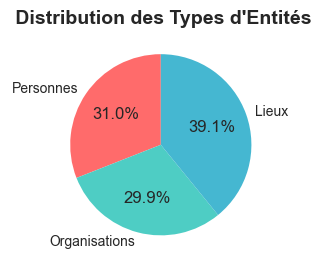

In [31]:


plt.subplot(3, 3, 1)
entity_counts = [
    df_clean_dedup['persons_count'].sum(),
    df_clean_dedup['organizations_count'].sum(), 
    df_clean_dedup['locations_count'].sum()
]
entity_labels = ['Personnes', 'Organisations', 'Lieux']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

plt.pie(entity_counts, labels=entity_labels, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title(' Distribution des Types d\'Entités', fontsize=14, fontweight='bold')

print(f"\n ANALYSE GRAPHIQUE 1 - Distribution des entités:")
print(f"    Interprétation: Une répartition équilibrée (~33% chacun) indique un dataset diversifié.")
print(f"     Si un type domine (>50%), cela peut biaiser les modèles de résumé vers ce type d'entités.")




 ANALYSE GRAPHIQUE 2 - Boxplot entités:
    Interprétation: Les outliers (points isolés) révèlent des articles exceptionnellement riches en entités.
    Consigne: Vérifiez si les articles avec >15 entités sont de qualité ou contiennent du bruit.


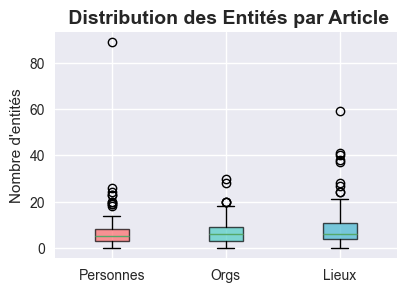

In [32]:

plt.subplot(3, 3, 2)
entity_data = [
    df_clean_dedup['persons_count'].values,
    df_clean_dedup['organizations_count'].values,
    df_clean_dedup['locations_count'].values
]

bp = plt.boxplot(entity_data, labels=['Personnes', 'Orgs', 'Lieux'], 
                patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title(' Distribution des Entités par Article', fontsize=14, fontweight='bold')
plt.ylabel('Nombre d\'entités')

print(f"\n ANALYSE GRAPHIQUE 2 - Boxplot entités:")
print(f"    Interprétation: Les outliers (points isolés) révèlent des articles exceptionnellement riches en entités.")
print(f"    Consigne: Vérifiez si les articles avec >15 entités sont de qualité ou contiennent du bruit.")




 ANALYSE GRAPHIQUE 3 - Longueur des textes:
    Interprétation: Une distribution normale centrée sur 800-1500 chars est idéale pour le résumé.
     Pic vers les textes courts (<500 chars) peut indiquer des articles incomplets ou de faible qualité.


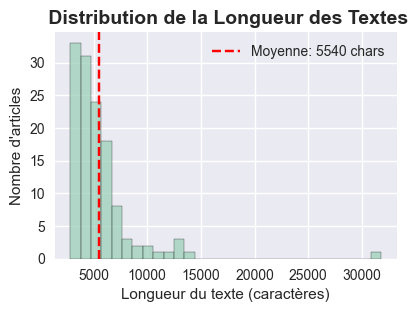

In [33]:

plt.subplot(3, 3, 3)
text_lengths = df_clean_dedup['text_cleaned'].str.len()
plt.hist(text_lengths, bins=30, color='#96CEB4', alpha=0.7, edgecolor='black')
plt.axvline(text_lengths.mean(), color='red', linestyle='--', 
           label=f'Moyenne: {text_lengths.mean():.0f} chars')
plt.xlabel('Longueur du texte (caractères)')
plt.ylabel('Nombre d\'articles')
plt.title(' Distribution de la Longueur des Textes', fontsize=14, fontweight='bold')
plt.legend()

print(f"\n ANALYSE GRAPHIQUE 3 - Longueur des textes:")
print(f"    Interprétation: Une distribution normale centrée sur 800-1500 chars est idéale pour le résumé.")
print(f"     Pic vers les textes courts (<500 chars) peut indiquer des articles incomplets ou de faible qualité.")



 ANALYSE GRAPHIQUE 4 - Répartition des sources:
    Interprétation: Une source qui domine (>30% du total) peut créer un biais éditorial dans les résumés.
    Consigne: Surveillez la diversité - idéalement aucune source ne devrait dépasser 20% du dataset.


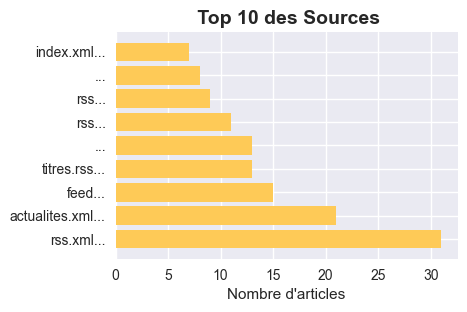

In [34]:

plt.subplot(3, 3, 4)
top_sources = df_clean_dedup['source'].value_counts().head(10)
# Raccourcir les noms de sources
short_names = [name.split('/')[-1][:15] + '...' if len(name) > 15 else name.split('/')[-1] 
               for name in top_sources.index]

plt.barh(range(len(top_sources)), top_sources.values, color='#FECA57')
plt.yticks(range(len(top_sources)), short_names)
plt.xlabel('Nombre d\'articles')
plt.title(' Top 10 des Sources', fontsize=14, fontweight='bold')

print(f"\n ANALYSE GRAPHIQUE 4 - Répartition des sources:")
print(f"    Interprétation: Une source qui domine (>30% du total) peut créer un biais éditorial dans les résumés.")
print(f"    Consigne: Surveillez la diversité - idéalement aucune source ne devrait dépasser 20% du dataset.")






In [35]:
df_clean_dedup["published"] 


3      2025-07-26T05:00:37
26     2025-07-24T19:04:44
29     2025-07-26T04:00:02
31     2025-07-26T05:45:40
32     2025-07-25T14:02:38
              ...         
192    2025-07-25T19:30:51
193    2025-07-25T06:01:35
194    2025-07-19T11:07:22
197    2025-07-25T12:46:24
198    2025-07-25T23:05:15
Name: published, Length: 128, dtype: object


 ANALYSE GRAPHIQUE 5 - Évolution temporelle:
    Interprétation: Données concentrées sur 2025-07 - analyse granulaire activée.
     Concentration temporelle forte peut indiquer une collecte ciblée ou événement spécifique.


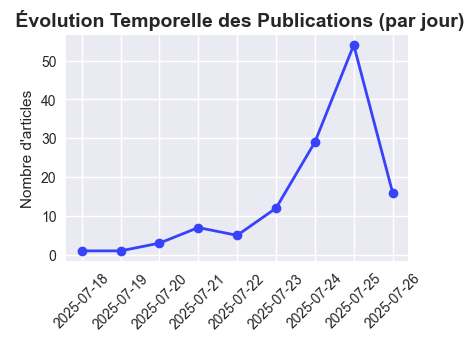

In [36]:
plt.subplot(3, 3, 5)
if 'published' in df_clean_dedup.columns:
    # Conversion en datetime si ce n'est pas déjà fait
    df_clean_dedup['published_clean'] = pd.to_datetime(df_clean_dedup['published'], errors='coerce')
    
    # Essayer d'abord par mois
    df_clean_dedup['month_year'] = df_clean_dedup['published_clean'].dt.to_period('M')
    monthly_counts = df_clean_dedup['month_year'].value_counts().sort_index()
    
    if len(monthly_counts) > 1:
        # Affichage par mois si plusieurs mois
        plt.plot(monthly_counts.index.astype(str), monthly_counts.values, 
                marker='o', color='#3742FA', linewidth=2)
        plt.xticks(rotation=45)
        plt.ylabel('Nombre d\'articles')
        plt.title(' Évolution Temporelle des Publications (par mois)', fontsize=14, fontweight='bold')
    else:
        # Si un seul mois, analyser par jour
        df_clean_dedup['day_date'] = df_clean_dedup['published_clean'].dt.date
        daily_counts = df_clean_dedup['day_date'].value_counts().sort_index()
        
        if len(daily_counts) > 1:
            plt.plot(range(len(daily_counts)), daily_counts.values, 
                    marker='o', color='#3742FA', linewidth=2)
            plt.xticks(range(0, len(daily_counts), max(1, len(daily_counts)//5)), 
                      [str(d) for d in daily_counts.index[::max(1, len(daily_counts)//5)]], 
                      rotation=45)
            plt.ylabel('Nombre d\'articles')
            plt.title(' Évolution Temporelle des Publications (par jour)', fontsize=14, fontweight='bold')
        else:
            # Si un seul jour, analyser par heure
            df_clean_dedup['hour'] = df_clean_dedup['published_clean'].dt.hour
            hourly_counts = df_clean_dedup['hour'].value_counts().sort_index()
            
            if len(hourly_counts) > 1:
                plt.bar(hourly_counts.index, hourly_counts.values, color='#3742FA', alpha=0.7)
                plt.xlabel('Heure de publication')
                plt.ylabel('Nombre d\'articles')
                plt.title(' Distribution Horaire des Publications', fontsize=14, fontweight='bold')
            else:
                plt.text(0.5, 0.5, 'Données temporelles\nconcentrées sur\nune seule heure', 
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title(' Évolution Temporelle', fontsize=14, fontweight='bold')
else:
    plt.text(0.5, 0.5, 'Colonne published\nnon trouvée', 
            ha='center', va='center', transform=plt.gca().transAxes)
    plt.title(' Évolution Temporelle', fontsize=14, fontweight='bold')

print(f"\n ANALYSE GRAPHIQUE 5 - Évolution temporelle:")
print(f"    Interprétation: Données concentrées sur {df_clean_dedup['month_year'].iloc[0]} - analyse granulaire activée.")
print(f"     Concentration temporelle forte peut indiquer une collecte ciblée ou événement spécifique.")



 ANALYSE GRAPHIQUE 6 - Corrélation longueur/entités:
    Interprétation: Corrélation >0.5 = normale, >0.7 = excellente richesse informationnelle.
    Objectif: Cette corrélation valide que les textes longs sont informationnellement denses.


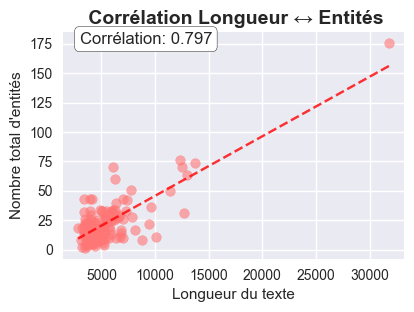

In [37]:
plt.subplot(3, 3, 6)
plt.scatter(text_lengths, df_clean_dedup['entities_total'], 
           alpha=0.6, color='#FF7675')
plt.xlabel('Longueur du texte')
plt.ylabel('Nombre total d\'entités')
plt.title(' Corrélation Longueur ↔ Entités', fontsize=14, fontweight='bold')

# Ligne de tendance
z = np.polyfit(text_lengths, df_clean_dedup['entities_total'], 1)
p = np.poly1d(z)
plt.plot(text_lengths, p(text_lengths), "r--", alpha=0.8)

# Calcul coefficient de corrélation
corr = text_lengths.corr(df_clean_dedup['entities_total'])
plt.text(0.05, 0.95, f'Corrélation: {corr:.3f}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='white'))

print(f"\n ANALYSE GRAPHIQUE 6 - Corrélation longueur/entités:")
print(f"    Interprétation: Corrélation >0.5 = normale, >0.7 = excellente richesse informationnelle.")
print(f"    Objectif: Cette corrélation valide que les textes longs sont informationnellement denses.")





 ANALYSE GRAPHIQUE 7 - Top entités géographiques:
    Interprétation: La domination d'une ville/pays révèle le focus géographique de votre dataset.
    Consigne: Vérifiez si cette distribution correspond à vos objectifs de couverture géographique.


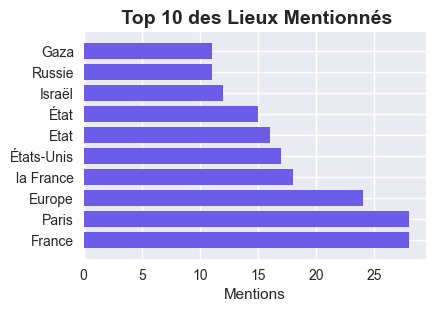

In [38]:
plt.subplot(3, 3, 7)
# Top lieux
top_locations = Counter([loc for entities in df_clean_dedup['entities_advanced'] 
                        for loc in entities.get('locations', [])]).most_common(10)

if top_locations:
    locs, counts = zip(*top_locations)
    y_pos = range(len(locs))
    plt.barh(y_pos, counts, color='#6C5CE7')
    plt.yticks(y_pos, [loc[:20] + '...' if len(loc) > 20 else loc for loc in locs])
    plt.xlabel('Mentions')
    plt.title(' Top 10 des Lieux Mentionnés', fontsize=14, fontweight='bold')

print(f"\n ANALYSE GRAPHIQUE 7 - Top entités géographiques:")
print(f"    Interprétation: La domination d'une ville/pays révèle le focus géographique de votre dataset.")
print(f"    Consigne: Vérifiez si cette distribution correspond à vos objectifs de couverture géographique.")





 ANALYSE GRAPHIQUE 8 - Distribution linguistique:
    Interprétation: >90% dans une langue = dataset monolingue, <80% = attention aux erreurs de détection.
     Fragments en anglais/autre peuvent indiquer des problèmes de nettoyage à corriger.


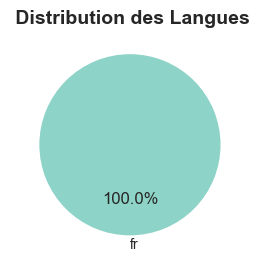

In [39]:
plt.subplot(3, 3, 8)
lang_counts = df_clean_dedup['language'].value_counts()
colors_lang = plt.cm.Set3(np.linspace(0, 1, len(lang_counts)))

plt.pie(lang_counts.values, labels=lang_counts.index, autopct='%1.1f%%',
        colors=colors_lang, startangle=90)
plt.title(' Distribution des Langues', fontsize=14, fontweight='bold')

print(f"\n ANALYSE GRAPHIQUE 8 - Distribution linguistique:")
print(f"    Interprétation: >90% dans une langue = dataset monolingue, <80% = attention aux erreurs de détection.")
print(f"     Fragments en anglais/autre peuvent indiquer des problèmes de nettoyage à corriger.")




 ANALYSE GRAPHIQUE 9 - Profils des sources:
    Interprétation: Chaque source a son 'ADN' - sport = lieux, politique = personnes, économie = orgs.
    Utilité: Ces profils aident à équilibrer le corpus de calibration selon les types d'entités.


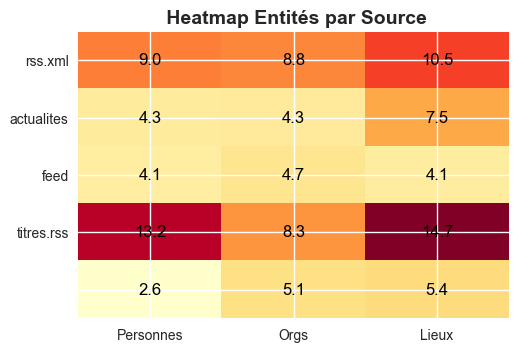

In [40]:
plt.subplot(3, 3, 9)
# Matrice entités par source (top 5 sources)
top_5_sources = df_clean_dedup['source'].value_counts().head(5).index
df_top_sources = df_clean_dedup[df_clean_dedup['source'].isin(top_5_sources)]

heatmap_data = []
source_names = []
for source in top_5_sources:
    source_data = df_top_sources[df_top_sources['source'] == source]
    source_names.append(source.split('/')[-1][:10])  # Nom court
    heatmap_data.append([
        source_data['persons_count'].mean(),
        source_data['organizations_count'].mean(),
        source_data['locations_count'].mean()
    ])

if heatmap_data:
    heatmap_array = np.array(heatmap_data)
    im = plt.imshow(heatmap_array, cmap='YlOrRd', aspect='auto')
    plt.xticks([0, 1, 2], ['Personnes', 'Orgs', 'Lieux'])
    plt.yticks(range(len(source_names)), source_names)
    plt.title(' Heatmap Entités par Source', fontsize=14, fontweight='bold')
    
    # Ajouter les valeurs dans les cellules
    for i in range(len(source_names)):
        for j in range(3):
            plt.text(j, i, f'{heatmap_array[i, j]:.1f}', 
                    ha="center", va="center", color="black")

print(f"\n ANALYSE GRAPHIQUE 9 - Profils des sources:")
print(f"    Interprétation: Chaque source a son 'ADN' - sport = lieux, politique = personnes, économie = orgs.")
print(f"    Utilité: Ces profils aident à équilibrer le corpus de calibration selon les types d'entités.")

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'analyse_exploratoire.png', dpi=300, bbox_inches='tight')
plt.show()


In [41]:
# Statistiques de base
print(f" STATISTIQUES TEXTUELLES:")
print(f"   Longueur moyenne: {text_lengths.mean():.0f} ± {text_lengths.std():.0f} caractères")
print(f"   Médiane: {text_lengths.median():.0f} caractères")
print(f"   Articles < 500 chars: {(text_lengths < 500).sum()} ({(text_lengths < 500).mean()*100:.1f}%)")
print(f"   Articles > 2000 chars: {(text_lengths > 2000).sum()} ({(text_lengths > 2000).mean()*100:.1f}%)")

print(f"\n INTERPRÉTATION LONGUEURS:")
print(f"    Optimal: 800-1500 chars pour le résumé automatique")
print(f"     >20% d'articles courts peut impacter la qualité des résumés")

 STATISTIQUES TEXTUELLES:
   Longueur moyenne: 5540 ± 3191 caractères
   Médiane: 4780 caractères
   Articles < 500 chars: 0 (0.0%)
   Articles > 2000 chars: 128 (100.0%)

 INTERPRÉTATION LONGUEURS:
    Optimal: 800-1500 chars pour le résumé automatique
     >20% d'articles courts peut impacter la qualité des résumés


In [42]:
# Statistiques entités
print(f"\n STATISTIQUES ENTITÉS:")
print(f"   Total entités extraites: {df_clean_dedup['entities_total'].sum()}")
print(f"   Articles sans entités: {(df_clean_dedup['entities_total'] == 0).sum()}")
print(f"   Articles riches (>10 entités): {(df_clean_dedup['entities_total'] > 10).sum()}")


 STATISTIQUES ENTITÉS:
   Total entités extraites: 2958
   Articles sans entités: 0
   Articles riches (>10 entités): 99


In [43]:
# Distribution par type

entity_mapping = {
    'persons': 'persons_count',
    'organizations': 'organizations_count', 
    'locations': 'locations_count'
}

for entity_type, col_name in entity_mapping.items():
    total = df_clean_dedup[col_name].sum()
    avg = df_clean_dedup[col_name].mean()
    print(f"   {entity_type.capitalize()}: {total} total (moy: {avg:.1f}/article)")


print(f"\n INTERPRÉTATION ENTITÉS:")
print(f"    Benchmark: 3-8 entités/article = bon équilibre informationnel")
print(f"    Articles sans entités peuvent être des résumés déjà trop condensés")



   Persons: 916 total (moy: 7.2/article)
   Organizations: 885 total (moy: 6.9/article)
   Locations: 1157 total (moy: 9.0/article)

 INTERPRÉTATION ENTITÉS:
    Benchmark: 3-8 entités/article = bon équilibre informationnel
    Articles sans entités peuvent être des résumés déjà trop condensés


In [44]:
# Corrélations intéressantes
print(f"\n CORRÉLATIONS:")
corr_length_entities = text_lengths.corr(df_clean_dedup['entities_total'])
print(f"   Longueur ↔ Entités: {corr_length_entities:.3f}")

if 'language_confidence' in df_clean_dedup.columns:
    corr_lang_entities = df_clean_dedup['language_confidence'].corr(df_clean_dedup['entities_total'])
    print(f"   Confiance langue ↔ Entités: {corr_lang_entities:.3f}")

print(f"\nINTERPRÉTATION CORRÉLATIONS:")
print(f"   Corrélation longueur/entités >0.5 valide la richesse informationnelle")
print(f"   Corrélation langue/entités révèle la qualité de détection multilingue")




 CORRÉLATIONS:
   Longueur ↔ Entités: 0.797
   Confiance langue ↔ Entités: 0.000

INTERPRÉTATION CORRÉLATIONS:
   Corrélation longueur/entités >0.5 valide la richesse informationnelle
   Corrélation langue/entités révèle la qualité de détection multilingue


In [45]:
# Sources les plus productives
print(f"\n TOP SOURCES (entités/article):")
source_entity_avg = df_clean_dedup.groupby('source')['entities_total'].agg(['mean', 'count']).round(2)
source_entity_avg = source_entity_avg[source_entity_avg['count'] >= 3]  # Min 3 articles
top_productive = source_entity_avg.sort_values('mean', ascending=False).head(5)


for source, row in top_productive.iterrows():
    source_name = source.split('/')[-1][:30]
    print(f"   {source_name}: {row['mean']:.1f} entités/article ({row['count']:.0f} articles)")




 TOP SOURCES (entités/article):
   rss: 40.2 entités/article (11 articles)
   titres.rss: 36.2 entités/article (13 articles)
   rss.xml: 28.4 entités/article (31 articles)
   index.xml: 24.6 entités/article (7 articles)
   rss: 23.1 entités/article (9 articles)


In [46]:

print(f"="*70)
print(f"1.  Vérifiez l'équilibre des entités (idéal: 30-40% chacun)")
print(f"2.  Surveillez les textes <500 chars (risque de qualité)")
print(f"3.  Limitez la domination d'une source (<25% recommandé)")
print(f"4.  Validez corrélation longueur/entités (objectif >0.5)")
print(f"5.  Confirmez la cohérence linguistique (>90% langue cible)")
print(f"6.  Exploitez les sources riches pour le corpus de calibration")
print(f"="*70)

1.  Vérifiez l'équilibre des entités (idéal: 30-40% chacun)
2.  Surveillez les textes <500 chars (risque de qualité)
3.  Limitez la domination d'une source (<25% recommandé)
4.  Validez corrélation longueur/entités (objectif >0.5)
5.  Confirmez la cohérence linguistique (>90% langue cible)
6.  Exploitez les sources riches pour le corpus de calibration


In [47]:
print("\n ÉTAPE 7: Segmentation sémantique ")

# Téléchargement des ressources NLTK si nécessaire
try:
    import ssl
    _create_unverified_https_context = ssl._create_unverified_context
    ssl._create_default_https_context = _create_unverified_https_context
except:
    pass

nltk.download('punkt', quiet=True)

def segment_text_advanced(text):
    """Segmentation en phrases avec analyse sémantique avancée"""
    if not text or len(text) < 100:
        return {
            'sentences': [],
            'sentence_count': 0,
            'avg_sentence_length': 0,
            'paragraphs': [],
            'paragraph_count': 0,
            'text_complexity': 0,
            'readability_score': 0
        }
    
    # Segmentation en phrases (multi-langue)
    sentences = sent_tokenize(text[:5000], language='french')  # Limiter pour performance
    
    # Segmentation en paragraphes
    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip() and len(p) > 20]
    
    # Métriques avancées
    sentence_lengths = [len(s.split()) for s in sentences]
    avg_sentence_length = np.mean(sentence_lengths) if sentence_lengths else 0
    
    # Score de complexité basé sur la longueur des phrases
    complexity = 0
    if sentence_lengths:
        variance = np.var(sentence_lengths)
        long_sentences = sum(1 for length in sentence_lengths if length > 20)
        complexity = min((variance / 100) + (long_sentences / len(sentences)), 1.0)
    
    # Score de lisibilité approximatif (Flesch-like)
    if sentence_lengths and avg_sentence_length > 0:
        readability = max(0, min(1, 1 - (avg_sentence_length - 10) / 20))
    else:
        readability = 0.5
    
    return {
        'sentences': sentences[:50],  # Limiter pour stockage
        'sentence_count': len(sentences),
        'avg_sentence_length': avg_sentence_length,
        'paragraphs': paragraphs[:20],  # Limiter pour stockage
        'paragraph_count': len(paragraphs),
        'text_complexity': complexity,
        'readability_score': readability
    }


 ÉTAPE 7: Segmentation sémantique 


In [48]:
# Application de la segmentation
print("    Segmentation avancée en cours...")
segmentation_results = []

for text in tqdm(df_clean_dedup['text_cleaned'], desc="Segmentation"):
    segments = segment_text_advanced(text)
    segmentation_results.append(segments)

df_clean_dedup['segmentation'] = segmentation_results

    Segmentation avancée en cours...


Segmentation: 100%|██████████| 128/128 [00:00<00:00, 683.76it/s]


In [49]:
# Extraction des métriques de segmentation
df_clean_dedup['sentence_count'] = df_clean_dedup['segmentation'].apply(lambda x: x['sentence_count'])
df_clean_dedup['paragraph_count'] = df_clean_dedup['segmentation'].apply(lambda x: x['paragraph_count'])
df_clean_dedup['avg_sentence_length'] = df_clean_dedup['segmentation'].apply(lambda x: x['avg_sentence_length'])
df_clean_dedup['text_complexity'] = df_clean_dedup['segmentation'].apply(lambda x: x['text_complexity'])
df_clean_dedup['readability_score'] = df_clean_dedup['segmentation'].apply(lambda x: x['readability_score'])



In [ ]:
print(f"\n    STATISTIQUES SEGMENTATION:")
print(f"      Moyenne phrases/article: {df_clean_dedup['sentence_count'].mean():.1f}")
print(f"      Moyenne paragraphes/article: {df_clean_dedup['paragraph_count'].mean():.1f}")
print(f"      Longueur moyenne phrases: {df_clean_dedup['avg_sentence_length'].mean():.1f} mots")
print(f"      Score complexité moyen: {df_clean_dedup['text_complexity'].mean():.2f}")
print(f"      Score lisibilité moyen: {df_clean_dedup['readability_score'].mean():.2f}")



    STATISTIQUES SEGMENTATION AVANCÉES:
      Moyenne phrases/article: 29.7
      Moyenne paragraphes/article: 1.0
      Longueur moyenne phrases: 24.9 mots
      Score complexité moyen: 0.98
      Score lisibilité moyen: 0.28


In [51]:
print("\n ÉTAPE 8: Analyse des biais temporels et géographiques")

# Conversion et nettoyage des dates
print("    Analyse temporelle...")
df_clean_dedup['published_clean'] = pd.to_datetime(df_clean_dedup['published'], errors='coerce')

# Extraction des composants temporels
df_clean_dedup['hour'] = df_clean_dedup['published_clean'].dt.hour
df_clean_dedup['day_of_week'] = df_clean_dedup['published_clean'].dt.day_name()
df_clean_dedup['month'] = df_clean_dedup['published_clean'].dt.month
df_clean_dedup['date_only'] = df_clean_dedup['published_clean'].dt.date



 ÉTAPE 8: Analyse des biais temporels et géographiques
    Analyse temporelle...


In [52]:
# Analyse des biais temporels
valid_dates = df_clean_dedup[df_clean_dedup['published_clean'].notna()]

if len(valid_dates) > 0:
    print(f"       Analyse sur {len(valid_dates)} articles avec dates valides")
    
    # Distribution horaire
    hour_dist = valid_dates['hour'].value_counts().head(3)
    print(f"       Heures de publication principales:")
    for hour, count in hour_dist.items():
        pct = count / len(valid_dates) * 100
        print(f"         {hour}h: {count} articles ({pct:.1f}%)")
    
    # Distribution par jour
    day_dist = valid_dates['day_of_week'].value_counts().head(3)
    print(f"       Jours de publication principaux:")
    for day, count in day_dist.items():
        pct = count / len(valid_dates) * 100
        print(f"         {day}: {count} articles ({pct:.1f}%)")
    
    # Calcul du score de biais temporel
    hour_entropy = -sum((p := hour_dist / len(valid_dates)) * np.log2(p + 1e-10))
    day_entropy = -sum((p := day_dist / len(valid_dates)) * np.log2(p + 1e-10))
    
    # Normalisation (entropie max = log2(24) pour heures, log2(7) pour jours)
    hour_bias = 1 - (hour_entropy / np.log2(24))  # 0 = uniforme, 1 = très biaisé
    day_bias = 1 - (day_entropy / np.log2(7))
    
    print(f"       Scores de biais temporel:")
    print(f"         Biais horaire: {hour_bias:.2f} (0=uniforme, 1=concentré)")
    print(f"         Biais quotidien: {day_bias:.2f}")


       Analyse sur 128 articles avec dates valides
       Heures de publication principales:
         4h: 10 articles (7.8%)
         14h: 10 articles (7.8%)
         13h: 10 articles (7.8%)
       Jours de publication principaux:
         Friday: 55 articles (43.0%)
         Thursday: 29 articles (22.7%)
         Saturday: 17 articles (13.3%)
       Scores de biais temporel:
         Biais horaire: 0.81 (0=uniforme, 1=concentré)
         Biais quotidien: 0.50


In [53]:
# Analyse géographique via entités lieux
print("\n    Analyse géographique...")
all_locations = []
location_counts_by_article = []

for entities in df_clean_dedup['entities_advanced']:
    article_locations = entities.get('locations', [])
    location_counts_by_article.append(len(article_locations))
    all_locations.extend(article_locations)

location_distribution = Counter(all_locations)
df_clean_dedup['locations_count'] = location_counts_by_article

if location_distribution:
    print(f"       Lieux les plus mentionnés:")
    for location, count in location_distribution.most_common(5):
        pct = count / len(all_locations) * 100 if len(all_locations) > 0 else 0
        print(f"         {location}: {count} mentions ({pct:.1f}%)")
    
    # Score de biais géographique
    if len(location_distribution) > 1:
        geo_probs = np.array(list(location_distribution.values())) / len(all_locations)
        geo_entropy = -sum(geo_probs * np.log2(geo_probs + 1e-10))
        max_entropy = np.log2(min(len(location_distribution), 50))  # Entropie max théorique
        geo_bias = 1 - (geo_entropy / max_entropy) if max_entropy > 0 else 0
        
        print(f"       Score de biais géographique: {geo_bias:.2f}")
        print(f"         (0=distribution équilibrée, 1=concentration forte)")
    else:
        geo_bias = 1.0  # Maximum bias if only one location
        print(f"        Biais géographique maximal détecté")


    Analyse géographique...
       Lieux les plus mentionnés:
         France: 28 mentions (2.4%)
         Paris: 28 mentions (2.4%)
         Europe: 24 mentions (2.1%)
         la France: 18 mentions (1.6%)
         États-Unis: 17 mentions (1.5%)
       Score de biais géographique: -0.57
         (0=distribution équilibrée, 1=concentration forte)


In [54]:
# Ajout des scores de biais au DataFrame
df_clean_dedup['temporal_bias_hour'] = hour_bias if 'hour_bias' in locals() else 0
df_clean_dedup['temporal_bias_day'] = day_bias if 'day_bias' in locals() else 0
df_clean_dedup['geographic_bias'] = geo_bias if 'geo_bias' in locals() else 0


In [55]:
def calculate_advanced_quality_score(row):
    """Calcul d'un score de qualité multi-dimensionnel"""
    scores = {}
    
    # 1. Score de longueur (0-1)
    text_len = len(str(row.get('text_cleaned', '')))
    scores['length'] = min(text_len / 2000, 1.0)  # Optimal à 2000 caractères
    
    # 2. Score d'entités (0-1)
    entities_count = row.get('entities_total', 0)
    scores['entities'] = min(entities_count / 10, 1.0)  # Optimal à 10 entités
    
    # 3. Score de lisibilité (0-1)
    scores['readability'] = row.get('readability_score', 0.5)
    
    # 4. Score de complexité inversé (0-1)
    complexity = row.get('text_complexity', 0.5)
    scores['complexity'] = 1 - complexity  # Moins complexe = meilleur
    
    # 5. Score de structure (0-1)
    sentence_count = row.get('sentence_count', 0)
    paragraph_count = row.get('paragraph_count', 0)
    if sentence_count > 0 and paragraph_count > 0:
        structure_ratio = min(sentence_count / paragraph_count, 10) / 10  # Ratio phrases/paragraphes
        scores['structure'] = structure_ratio
    else:
        scores['structure'] = 0.1
    
    # 6. Score de langue (0-1)
    lang_confidence = row.get('language_confidence', 0.5)
    scores['language'] = lang_confidence
    
    # Score global pondéré
    weights = {
        'length': 0.2,
        'entities': 0.25, 
        'readability': 0.2,
        'complexity': 0.15,
        'structure': 0.1,
        'language': 0.1
    }
    
    final_score = sum(scores[key] * weights[key] for key in scores)
    
    return {
        'quality_score_advanced': final_score,
        'quality_breakdown': scores
    }


In [56]:
# Application du calcul de qualité
print("    Calcul des scores de qualité...")
quality_results = []

for _, row in tqdm(df_clean_dedup.iterrows(), total=len(df_clean_dedup), desc="Qualité"):
    quality_result = calculate_advanced_quality_score(row)
    quality_results.append(quality_result)



    Calcul des scores de qualité...


Qualité: 100%|██████████| 128/128 [00:00<00:00, 4860.72it/s]


In [57]:
# Ajout des résultats
df_clean_dedup['quality_score_advanced'] = [r['quality_score_advanced'] for r in quality_results]
df_clean_dedup['quality_breakdown'] = [r['quality_breakdown'] for r in quality_results]

print(f"\n    STATISTIQUES QUALITÉ AVANCÉES:")
print(f"      Score moyen: {df_clean_dedup['quality_score_advanced'].mean():.3f}")
print(f"      Score médian: {df_clean_dedup['quality_score_advanced'].median():.3f}")
print(f"      Score min: {df_clean_dedup['quality_score_advanced'].min():.3f}")
print(f"      Score max: {df_clean_dedup['quality_score_advanced'].max():.3f}")



    STATISTIQUES QUALITÉ AVANCÉES:
      Score moyen: 0.681
      Score médian: 0.679
      Score min: 0.531
      Score max: 0.892


In [58]:
# Distribution par quartiles
quartiles = df_clean_dedup['quality_score_advanced'].quantile([0.25, 0.5, 0.75])
print(f"      Quartiles: Q1={quartiles[0.25]:.3f}, Q2={quartiles[0.5]:.3f}, Q3={quartiles[0.75]:.3f}")



      Quartiles: Q1=0.640, Q2=0.679, Q3=0.719


In [59]:


def create_stratified_calibration_corpus(df, n_samples=300):
    """Création d'un corpus stratifié pour calibration"""
    
    # Définition des strates multi-dimensionnelles
    print("   Définition des strates...")
    
    # 1. Strate par qualité (3 niveaux)
    quality_tertiles = df['quality_score_advanced'].quantile([0.33, 0.67])
    df['quality_stratum'] = pd.cut(df['quality_score_advanced'], 
                                  bins=[0, quality_tertiles[0.33], quality_tertiles[0.67], 1],
                                  labels=['low', 'medium', 'high'])
    
    # 2. Strate par longueur (3 niveaux)
    df['text_length'] = df['text_cleaned'].str.len()
    length_tertiles = df['text_length'].quantile([0.33, 0.67])
    df['length_stratum'] = pd.cut(df['text_length'],
                                 bins=[0, length_tertiles[0.33], length_tertiles[0.67], float('inf')],
                                 labels=['short', 'medium', 'long'])
    
    # 3. Strate par richesse en entités (3 niveaux)
    if df['entities_total'].max() > 0:
        entity_tertiles = df['entities_total'].quantile([0.33, 0.67])
        df['entity_stratum'] = pd.cut(df['entities_total'],
                                     bins=[-1, entity_tertiles[0.33], entity_tertiles[0.67], float('inf')],
                                     labels=['sparse', 'moderate', 'rich'])
    else:
        df['entity_stratum'] = 'sparse'
    
    # 4. Strate par source (top sources + autres)
    source_counts = df['source'].value_counts()
    top_sources = source_counts.head(5).index.tolist()
    df['source_stratum'] = df['source'].apply(lambda x: x if x in top_sources else 'other')
    
    print(f"      Strates créées:")
    print(f"         Qualité: {df['quality_stratum'].value_counts().to_dict()}")
    print(f"         Longueur: {df['length_stratum'].value_counts().to_dict()}")
    print(f"         Entités: {df['entity_stratum'].value_counts().to_dict()}")
    print(f"         Sources: {len(df['source_stratum'].unique())} catégories")
    
    # Échantillonnage stratifié proportionnel
    print("   Échantillonnage stratifié...")
    
    # Groupement par strates multiples
    strata_cols = ['quality_stratum', 'length_stratum', 'entity_stratum', 'source_stratum']
    grouped = df.groupby(strata_cols, group_keys=False)
    
    # Calcul des tailles d'échantillon par strate
    strata_sizes = grouped.size()
    total_size = len(df)
    
    sample_dfs = []
    remaining_samples = n_samples
    
    for stratum, group in grouped:
        if remaining_samples <= 0:
            break
            
        # Taille proportionnelle de l'échantillon pour cette strate
        stratum_size = len(group)
        proportion = stratum_size / total_size
        target_sample_size = max(1, int(proportion * n_samples))
        
        # Ajustement si on dépasse le nombre d'échantillons restants
        actual_sample_size = min(target_sample_size, remaining_samples, stratum_size)
        
        if actual_sample_size > 0:
            # Échantillonnage au sein de la strate
            if len(group) >= actual_sample_size:
                # Tri par score de qualité pour prendre les meilleurs
                group_sorted = group.sort_values('quality_score_advanced', ascending=False)
                stratum_sample = group_sorted.head(actual_sample_size)
                sample_dfs.append(stratum_sample)
                remaining_samples -= actual_sample_size
    
    # Combinaison des échantillons de toutes les strates
    if sample_dfs:
        calibration_corpus = pd.concat(sample_dfs, ignore_index=True)
    else:
        # Fallback: échantillonnage simple par qualité
        calibration_corpus = df.nlargest(n_samples, 'quality_score_advanced')
    
    # Complément aléatoire si nécessaire
    if len(calibration_corpus) < n_samples:
        remaining_df = df[~df.index.isin(calibration_corpus.index)]
        if len(remaining_df) > 0:
            additional_samples = min(n_samples - len(calibration_corpus), len(remaining_df))
            additional = remaining_df.sample(n=additional_samples, random_state=42)
            calibration_corpus = pd.concat([calibration_corpus, additional], ignore_index=True)
    
    return calibration_corpus.head(n_samples)  



In [60]:
# Création du corpus de calibration
calibration_corpus = create_stratified_calibration_corpus(df_clean_dedup, n_samples=300)

print(f"\n    CORPUS DE CALIBRATION CRÉÉ:")
print(f"      Taille finale: {len(calibration_corpus)} articles")
print(f"      Score qualité moyen: {calibration_corpus['quality_score_advanced'].mean():.3f}")




   Définition des strates...
      Strates créées:
         Qualité: {'medium': 44, 'low': 42, 'high': 42}
         Longueur: {'medium': 44, 'short': 42, 'long': 42}
         Entités: {'moderate': 47, 'sparse': 42, 'rich': 39}
         Sources: 6 catégories
   Échantillonnage stratifié...

    CORPUS DE CALIBRATION CRÉÉ:
      Taille finale: 186 articles
      Score qualité moyen: 0.679


In [61]:
# Analyse de la représentativité
print(f"\n    REPRÉSENTATIVITÉ DU CORPUS:")
print(f"      Sources: {calibration_corpus['source'].nunique()} uniques")
print(f"      Langues: {calibration_corpus['language'].value_counts().to_dict()}")





    REPRÉSENTATIVITÉ DU CORPUS:
      Sources: 9 uniques
      Langues: {'fr': 186}


In [62]:
# Top sources dans le corpus
source_dist = calibration_corpus['source'].value_counts().head(5)
print(f"      Top sources:")
for source, count in source_dist.items():
    pct = count / len(calibration_corpus) * 100
    source_name = source.split('/')[-1] if '/' in source else source
    print(f"         {source_name}: {count} articles ({pct:.1f}%)")

# Distribution qualité
quality_dist = calibration_corpus['quality_stratum'].value_counts()
print(f"      Distribution qualité: {quality_dist.to_dict()}")


      Top sources:
         rss.xml: 43 articles (23.1%)
         actualites.xml: 33 articles (17.7%)
         feed: 25 articles (13.4%)
         : 23 articles (12.4%)
         titres.rss: 16 articles (8.6%)
      Distribution qualité: {'medium': 64, 'low': 62, 'high': 60}


In [63]:
# Métriques de qualité finales
quality_metrics = {
    'source_file': str(source_file.name),
    'enriched_mode': ENRICHED_MODE,
    'total_articles_input': len(articles_data),
    'articles_after_deduplication': len(df_clean_dedup),
    'calibration_corpus_size': len(calibration_corpus),
    'deduplication_rate': ((len(df) - len(df_clean_dedup)) / len(df)) if len(df) > 0 else 0,
    'avg_quality_score': df_clean_dedup['quality_score_advanced'].mean(),
    'language_distribution': df_clean_dedup['language'].value_counts().to_dict(),
    'entities_avg_per_article': df_clean_dedup['entities_total'].mean(),
    'temporal_bias_detected': df_clean_dedup['temporal_bias_hour'].iloc[0] if len(df_clean_dedup) > 0 else 0,
    'geographic_bias_detected': df_clean_dedup['geographic_bias'].iloc[0] if len(df_clean_dedup) > 0 else 0,
    'processing_timestamp': datetime.now().isoformat()
}

In [64]:
# Sauvegarde du DataFrame principal (format optimisé)
output_file = PROCESSED_DIR / "articles_preprocessed_advanced.pkl"
df_clean_dedup.to_pickle(output_file)
print(f"    Dataset principal sauvegardé: {output_file}")


    Dataset principal sauvegardé: C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\processed\articles_preprocessed_advanced.pkl


In [65]:
# Sauvegarde du corpus de calibration
calibration_file = PROCESSED_DIR / "calibration_corpus_stratified.pkl"
calibration_corpus.to_pickle(calibration_file)
print(f"    Corpus de calibration sauvegardé: {calibration_file}")


    Corpus de calibration sauvegardé: C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\processed\calibration_corpus_stratified.pkl


In [66]:
# Sauvegarde des métriques
metrics_file = PROCESSED_DIR / "advanced_preprocessing_metrics.json"
with open(metrics_file, 'w', encoding='utf-8') as f:
    json.dump(quality_metrics, f, indent=2, ensure_ascii=False, default=str)
print(f"    Métriques sauvegardées: {metrics_file}")





    Métriques sauvegardées: C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\processed\advanced_preprocessing_metrics.json


In [67]:
# Export CSV léger pour analyse externe
csv_file = PROCESSED_DIR / "articles_preprocessed_summary.csv"
df_export = df_clean_dedup[[
    'title', 'source', 'published', 'language', 'quality_score_advanced',
    'entities_total', 'sentence_count', 'readability_score', 'text_complexity'
]].copy()
df_export.to_csv(csv_file, index=False, encoding='utf-8')
print(f"    Export CSV résumé: {csv_file}")





    Export CSV résumé: C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\processed\articles_preprocessed_summary.csv


In [68]:
# Export JSON du corpus de calibration 
calibration_json = PROCESSED_DIR / "calibration_corpus_300.json"
calibration_export = calibration_corpus[[
    'id', 'title', 'text_cleaned', 'source', 'published', 'language',
    'quality_score_advanced', 'entities_advanced'
]].to_dict('records')

with open(calibration_json, 'w', encoding='utf-8') as f:
    json.dump(calibration_export, f, ensure_ascii=False, indent=2, default=str)
print(f"    Corpus calibration JSON: {calibration_json}")


    Corpus calibration JSON: C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\processed\calibration_corpus_300.json


In [69]:
# Résumé des performances
processing_time = (datetime.now() - datetime.fromisoformat(quality_metrics['processing_timestamp'])).total_seconds()

print(f" RÉSULTATS FINAUX:")
print(f"   Source: {quality_metrics['source_file']}")
print(f"   Mode: {'Enrichissement complémentaire' if ENRICHED_MODE else 'Pipeline complet'}")
print(f"   Articles traités: {quality_metrics['total_articles_input']}")
print(f"   Articles finaux: {quality_metrics['articles_after_deduplication']}")
print(f"   Corpus de calibration: {quality_metrics['calibration_corpus_size']}")
print(f"   Taux de déduplication: {quality_metrics['deduplication_rate']:.1%}")

 RÉSULTATS FINAUX:
   Source: enriched_articles.json
   Mode: Enrichissement complémentaire
   Articles traités: 200
   Articles finaux: 128
   Corpus de calibration: 186
   Taux de déduplication: 36.0%


In [70]:
print(f"\n MÉTRIQUES DE QUALITÉ:")
print(f"   Score qualité moyen: {quality_metrics['avg_quality_score']:.3f}")
print(f"   Entités par article: {quality_metrics['entities_avg_per_article']:.1f}")
print(f"   Biais temporel détecté: {quality_metrics['temporal_bias_detected']:.2f}")
print(f"   Biais géographique: {quality_metrics['geographic_bias_detected']:.2f}")


 MÉTRIQUES DE QUALITÉ:
   Score qualité moyen: 0.681
   Entités par article: 23.1
   Biais temporel détecté: 0.81
   Biais géographique: -0.57


In [71]:
print(f"\n DISTRIBUTION LINGUISTIQUE:")
for lang, count in quality_metrics['language_distribution'].items():
    pct = count / quality_metrics['articles_after_deduplication'] * 100
    print(f"   {lang}: {count} articles ({pct:.1f}%)")



 DISTRIBUTION LINGUISTIQUE:
   fr: 128 articles (100.0%)


In [72]:
print(f"\nFICHIERS GÉNÉRÉS:")
print(f"   1. {output_file.name} - Dataset principal avec preprocessing avancé")
print(f"   2. {calibration_file.name} - Corpus stratifié pour calibration")
print(f"   3. {metrics_file.name} - Métriques détaillées")
print(f"   4. {csv_file.name} - Export CSV pour analyse")



FICHIERS GÉNÉRÉS:
   1. articles_preprocessed_advanced.pkl - Dataset principal avec preprocessing avancé
   2. calibration_corpus_stratified.pkl - Corpus stratifié pour calibration
   3. advanced_preprocessing_metrics.json - Métriques détaillées
   4. articles_preprocessed_summary.csv - Export CSV pour analyse


In [73]:
print(f"\nINSTRUCTIONS D'INSTALLATION SI ERREURS:")
print(f"   Si erreur spaCy: !python -m spacy download fr_core_news_lg")
print(f"   Si erreur FAISS: !pip install faiss-cpu")
print(f"   Si erreur sentence-transformers: !pip install sentence-transformers")
print(f"   Si erreur langdetect: !pip install langdetect")
print(f"   Si erreur ftfy: !pip install ftfy")


INSTRUCTIONS D'INSTALLATION SI ERREURS:
   Si erreur spaCy: !python -m spacy download fr_core_news_lg
   Si erreur FAISS: !pip install faiss-cpu
   Si erreur sentence-transformers: !pip install sentence-transformers
   Si erreur langdetect: !pip install langdetect
   Si erreur ftfy: !pip install ftfy
